<a href="https://colab.research.google.com/github/tbeka/lesion_segmentation/blob/main/lesion_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin lesion segmentation with SegNet.

In this notebook, I implemented and compared different deep learning architectures (SegNet and UNet) for binary segmentation of skin lesions using the PH4 dataset. The models were evaluated using various loss functions (BCE, Dice, and Focal loss), with SegNet using BCE loss achieving the best performance with an IoU of 0.65.



## Downloading dataset

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2024-10-22 19:30:36--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70 [following]
--2024-10-22 19:30:37--  https://www.dropbox.com/scl/fi/xk3foy6dv46dlhr2yp0xn/PH2Dataset.rar?rlkey=jmxki4aywtmr8ycf0b0bz9q70
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc75491afecdd6b6a5dab1642d06.dl.dropboxusercontent.com/cd/0/inline/Cc_R9rze6F6rSFP_2nwXLBGlZEKP7rrOWVOU8Jxgo0cyGUo_zeONbRp63683aZ0riOvtcwsuKT1Q2-tkMFq8vS5dMROA7r8WvmlkEVxccps1mx4uT0XbAT8299A0X6aNcSQ/file# [following]
--2024-10-22 19:30:39--  https://uc75491afecdd6b6a5dab1642d06.dl.dropboxusercontent.com/cd/0/inline/Cc_R9rze6F6rSFP_

In [2]:
!ls

PH2Dataset.rar	sample_data


In [3]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [4]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

## Resizing input images

In [5]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

## Previewing data

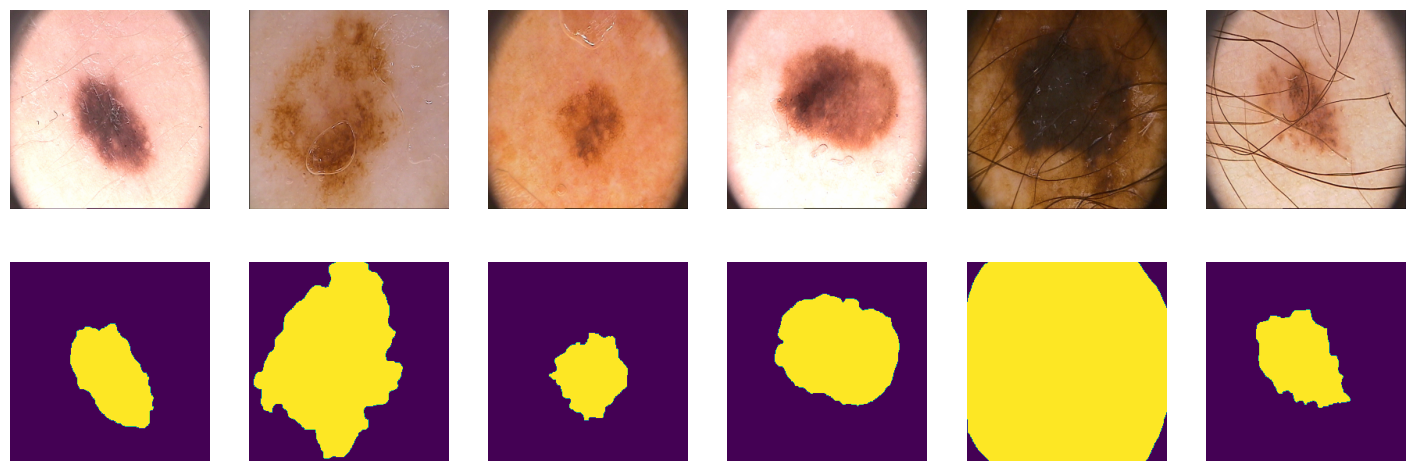

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

## Train-validation-test split

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [11]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Neural networks implementation
In this project, I will implement two different neural networks and two loss functions.

-----------------------------------------------------------------------------------------

# SegNet

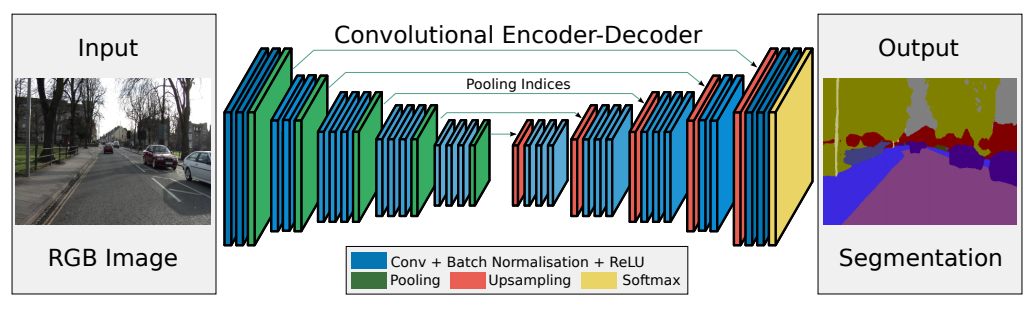

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [25]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                        nn.Conv2d(3, 64, 3, 1, 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 64, 3, 1, 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, 1, 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 128, 3, 1, 1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, 1, 1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, 3, 1, 1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, 3, 1, 1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 64 -> 32

        self.enc_conv3 =nn.Sequential(
                        nn.Conv2d(256, 512, 3, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512, 512, 3, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512, 512, 3, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True))
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv =nn.Sequential(
                        nn.Conv2d(512, 512, 3, 1, 1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(inplace=True))

        # Decoder (upsampling)
        self.unpool0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # Output 3 channels (assuming RGB output)
            nn.Sigmoid()
        )

    def forward(self, x):
    # Encoder
      e0 = self.enc_conv0(x)
      e0_p, idx0 = self.pool0(e0)
      e1 = self.enc_conv1(e0_p)
      e1_p, idx1 = self.pool1(e1)
      e2 = self.enc_conv2(e1_p)
      e2_p, idx2 = self.pool2(e2)
      e3 = self.enc_conv3(e2_p)
      e3_p, idx3 = self.pool3(e3)

      # Bottleneck
      b = self.bottleneck_conv(e3_p)

      # Decoder
      d0 = self.unpool0(b, idx3, output_size=e3.size())
      d0 = self.dec_conv0(d0)
      d1 = self.unpool1(d0, idx2, output_size=e2.size())
      d1 = self.dec_conv1(d1)
      d2 = self.unpool2(d1, idx1, output_size=e1.size())
      d2 = self.dec_conv2(d2)
      d3 = self.unpool3(d2, idx0, output_size=e0.size())
      d3 = self.dec_conv3(d3)  # No activation in the final layer

      if self.training:
        return d3  # During training, return sigmoid outputs for BCE loss
      else:
        return (d3 > 0.5).float()  # During inference, return binary mask

      return output

## Evaluation metrics

In this project, I will use the Intersection over Union metrics to evaluate my models.

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # Ensuring outputs and labels are on the same device
    outputs = outputs.to(labels.device)

    # Assuming outputs are of shape (batch_size, 3, H, W) and labels are (batch_size, 1, H, W)
    # We'll take the mean across the channel dimension to get a single channel prediction
    outputs = outputs.mean(dim=1, keepdim=True)

    # Converting to binary
    outputs = (outputs > 0.5).float()
    labels = labels.float()

    # Squeezing if necessary
    outputs = outputs.squeeze(1)
    labels = labels.squeeze(1)

    SMOOTH = 1e-8
    intersection = (outputs * labels).sum((1, 2))
    union = (outputs + labels).sum((1, 2)) - intersection

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds

    return thresholded

## Loss function

Since we are working with a binary segmentation, we can apply *binary cross-entropy*

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is ground truth and $\hat y$ is our model's output. $\sigma$ - is the *sigmoid function, which turns real numbers $\mathbb R$ into probability $[0,1]$.

However, this loss function suffers from numerical instability. Mainly, $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability during optimization. Thus, we will use a simpler but equivalent function:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [19]:
def bce_loss(y_real, y_pred):

    # Clamp y_pred to avoid log(0) and division by zero issues
    y_pred = torch.clamp(y_pred, min=1e-7, max=1 - 1e-7)

    # Computing the BCE loss
    loss = - (y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))

    return loss.mean()

## Training function

In [26]:

def train(model, opt, loss_fn, epochs, data_tr, data_val):
    model.to(device)
    X_val, Y_val = next(iter(data_val))
    X_val, Y_val = X_val.to(device), Y_val.to(device)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch + 1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights


            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        with torch.no_grad():
            Y_hat = model(X_val).detach().cpu()  # detach and put into cpu

        # Visualize results
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k + 1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k + 7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch + 1, epochs, avg_loss))
        plt.show()


## Inference function

In [27]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [35]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    device = next(model.parameters()).device  # Get the device of the model

    for X_batch, Y_label in data:
        # Move input data to the same device as the model
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)

        with torch.no_grad():  # Disable gradient computation
            Y_pred = model(X_batch)

        # Ensure Y_pred and Y_label are on the same device for the metric calculation
        scores += metric(Y_pred, Y_label).mean().item()

    print('IoU value:', scores / len(data))

# Training


In [29]:
model = SegNet().to(device)

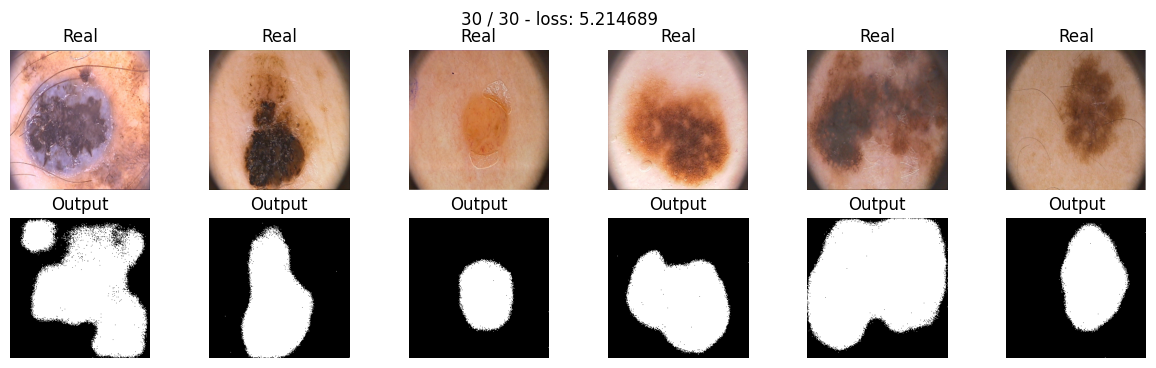

In [30]:
max_epochs = 30
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train(model, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [36]:
score_model(model, iou_pytorch, data_val)

IoU value: 0.656000018119812


-----------------------------------------------------------------------------------------

## Additional loss functions

## Dice coefficient:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

However, this function is not differentiable, so we will approximate it with:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$




In [37]:
def dice_loss(y_pred, y_real):
    # Ensure y_pred is a probability
    y_pred = torch.sigmoid(y_pred)

    # Adjust y_pred to match y_real's shape if necessary
    if y_pred.shape != y_real.shape:
        y_pred = y_pred.view(y_real.shape)

    # Flatten the tensors
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    # Calculate numerator (2 * intersection)
    num = 2 * (y_pred * y_real).sum() + 1e-8

    # Calculate denominator (sum of squares)
    den = (y_pred * y_pred).sum() + (y_real * y_real).sum() + 1e-8

    # Calculate Dice coefficient and return Dice loss
    res = 1 - (num / den)

    return res

## Testing dice loss

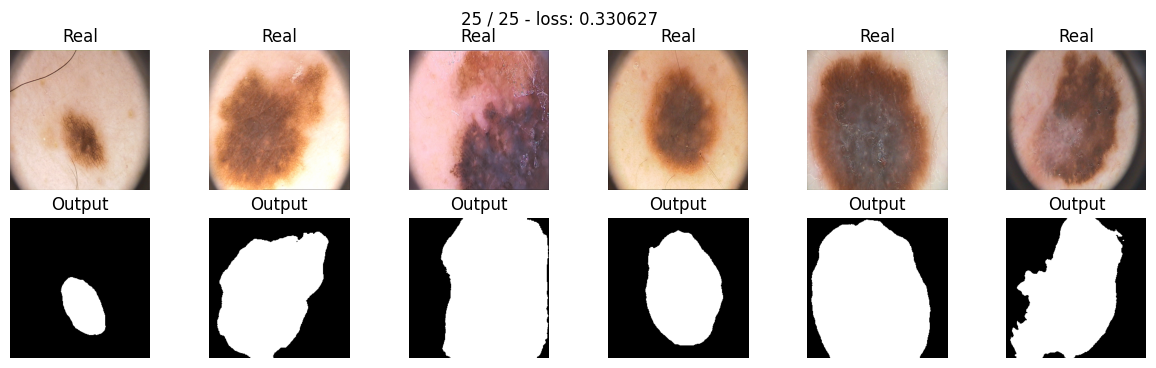

In [40]:
model_dice = SegNet().to(device)

max_epochs = 25
optimizer = optim.Adam(model_dice.parameters())
train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [41]:
score_model(model_dice, iou_pytorch, data_val)

IoU value: 0.6379999816417694


## Focal loss:


$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

and we will fix $\gamma=2$.

--------------------------------------------------------------------------------


In [42]:
def focal_loss(y_real, y_pred):
    # Clamping predictions for numerical stability
    y_pred = torch.clamp(y_pred, min=1e-7, max=1 - 1e-7)

    # Compute the cross-entropy loss
    ce_loss = - (y_real * torch.log(y_pred) + (1 - y_real) * torch.log(1 - y_pred))

    # Compute the focal loss
    pt = y_real * y_pred + (1 - y_real) * (1 - y_pred)
    focal_loss = 0.25 * (1 - pt) ** 2 * ce_loss

    # Return the average loss
    return focal_loss.mean()


## Testing focal loss

In [43]:
model_focal = SegNet().to(device)

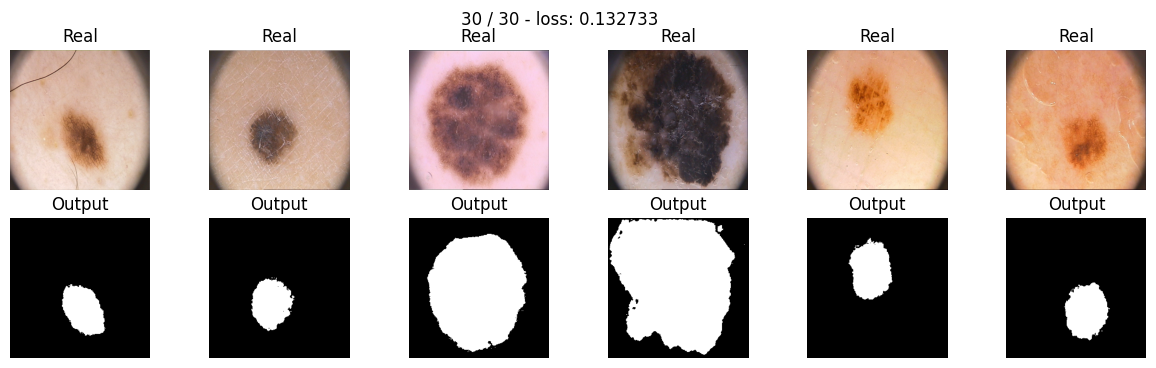

In [45]:
max_epochs = 30
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [46]:
score_model(model_focal, iou_pytorch, data_val)

IoU value: 0.6040000021457672


-----------------------------------------------------------------------------------------

# Additional neural networks

## U-Net

Now, we will implement U-Net for the same task.

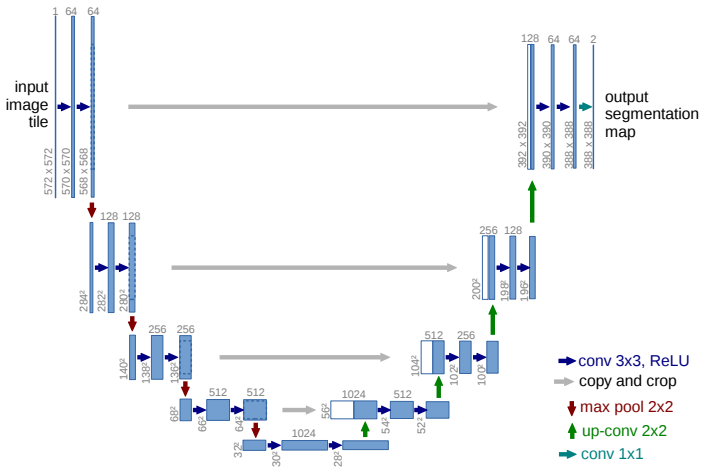

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [51]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = self._conv_block(in_channels, 64)
        self.pool0 = nn.MaxPool2d(2, 2)  # 256 -> 128
        self.enc_conv1 = self._conv_block(64, 128)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv2 = self._conv_block(128, 256)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv3 = self._conv_block(256, 512)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = self._conv_block(512, 1024)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = self._conv_block(1024, 512)
        self.upsample1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # 32 -> 64
        self.dec_conv1 = self._conv_block(512, 256)
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = self._conv_block(256, 128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = self._conv_block(128, 64)

        self.final_conv = nn.Sequential(
    nn.Conv2d(64, out_channels, kernel_size=1),
    #nn.Sigmoid()
)

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3))

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), e3], dim=1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), e2], dim=1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), e1], dim=1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], dim=1))

        output = self.final_conv(d3)
        if self.training:
          return d3  # During training, return sigmoid outputs for BCE loss
        else:
          return (d3 > 0.5).float()  # During inference, return binary mask

## Training with BCE loss

In [52]:
unet_model = UNet().to(device)

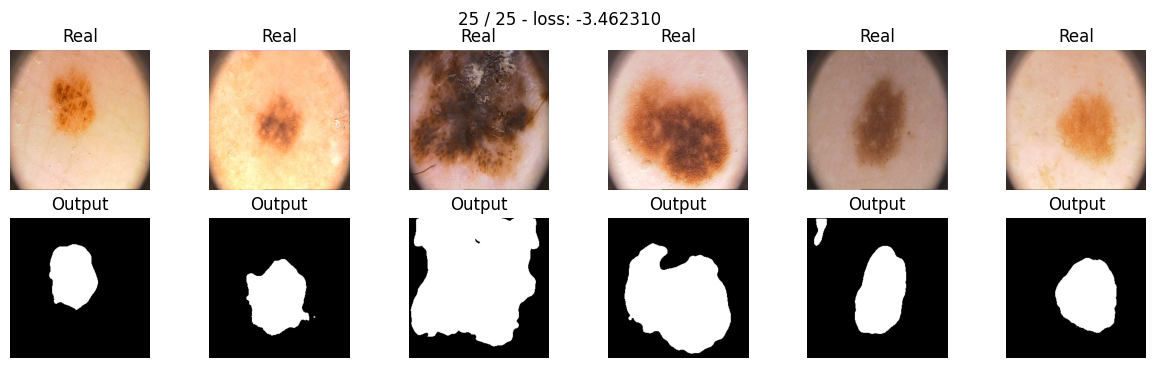

In [54]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 25, data_tr, data_val)

## Evaluation

In [55]:
score_model(unet_model, iou_pytorch, data_val)

IoU value: 0.6400000154972076


-----------------------------------------------------------------------------------------

## Conclusion

We received the following values:

| Model  | Loss Function | IoU Value |
|--------|--------------|-----------|
| SegNet | BCE          | 0.65      |
| SegNet | Dice         | 0.637     |
| SegNet | Focal        | 0.60      |
| UNet   | BCE          | 0.64      |

As we can see, the SegNet model and BCE loss combination performs the best among our four tests. However, all of the IoU values are similar so the advantage might be neglected. Instead, it would be beneficial to research the effect of various model hyperparameters.